# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc, get_sqrt_diag_cov_from_numpyro

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

feynmangpu02.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
# m, ev, lo, rsdb, pc, samp, mm
task_id = 2112230
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)
print("save path:", save_path)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)
# print("jax_enable_x64:", jconfig.read("jax_enable_x64"))

SLURM_ARRAY_TASK_ID: 2112230
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield/sMCLMC_nc4_ns64_nomm


# CONFIG
{'a_obs': 0.5,
 'box_shape': array([160., 160., 160.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.06},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
   

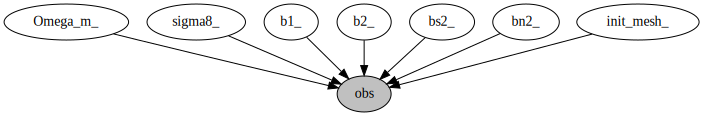

In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    if model.loc_fid['b1'] == 0:
        truth['b1'] = 0.

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir+"model.p")    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()
model.render()

## Run

### NUTS, HMC

In [4]:
continue_run = False
if continue_run:
    pass
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
    model.block()

    mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    init_params_ = jit(vmap(partial(model.init_model, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), mcmc.num_chains))
    # init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)
    
    if not os.path.exists(save_path + "_init_last_state.p"):
        print("# Warmupping...")
        init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
        mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
        ils = mcmc.last_state.z
    else:
        print("# Loading init_last_state")
        ils = pload(save_path + "_init_last_state.p").z
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

    # ################
    # from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    # mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    # kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    # kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    # kpk0 = model.spectrum(mesh0)
    # kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    # kpkobs = model.spectrum(truth['obs']-1)
    
    # print(ils.keys(), init_params_.keys())

    # mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    # mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    # print("MSEs:", mse_, mse_)

    # prob = 0.95
    # plt.figure(figsize=(12, 4))
    # plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    # plot_powtranscoh(*kptcs__, fill=prob)
    # plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    # plot_powtranscoh(*kptcs_, fill=prob)
    # plt.subplot(131)
    # plot_pow(*kpk0, 'k', label='true')
    # plot_pow(*kpkobs, ':', c='grey', label='obs')
    # plt.legend()
    # plt.subplot(133)
    # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    # plt.tight_layout()
    # plt.savefig(save_dir+f'init_glin_{task_id}.png')
    # # plt.savefig(f'init_glin_{task_id}.png')
    # ################    
    
    if model.loc_fid['b1'] == 0:
        print('no bias')
        init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_']} | ils
        # init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_','b1_','b2_','bs2_']} | ils
    else:
        init_params_ |= ils
        # init_params_ |= mcmc.last_state.z
    print(init_params_.keys())

    sqrt_diag_cov = vmap(partial(get_sqrt_diag_cov_from_numpyro, all=False))(pload(save_path + "_init_last_state.p"), init_params_)
    print(sqrt_diag_cov)

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()

# Loading init_last_state
dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])
{'Omega_m_': Array([1., 1., 1., 1.], dtype=float64), 'b1_': Array([1., 1., 1., 1.], dtype=float64, weak_type=True), 'b2_': Array([1., 1., 1., 1.], dtype=float64, weak_type=True), 'bn2_': Array([1., 1., 1., 1.], dtype=float64, weak_type=True), 'bs2_': Array([1., 1., 1., 1.], dtype=float64, weak_type=True), 'init_mesh_': Array([[[[1.14129929, 0.77848378, 0.99944522, ..., 1.39767568,
          1.15656668, 1.1052145 ],
         [0.71517936, 0.79474896, 0.82971843, ..., 1.46775155,
          1.52508418, 1.21221554],
         [0.84824379, 0.76295636, 0.83995171, ..., 1.25143877,
          1.178103  , 1.44688352],
         ...,
         [1.17357345, 0.80327021, 1.00765324, ..., 1.30250787,
          1.37054318, 0.97768533],
         [1.18274685, 0.74737128, 0.96315964, ..., 1.25480316,
          1.06644527, 1.20930551],
         [0.92395928, 0.66121187, 0.79412074, ..., 1.45873063,
       

In [27]:
pth = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sNUTS_nc4_ns1024'
aa = dict(jnp.load(pth+'_init_0.npz'))
bb = dict(jnp.load(pth+'_0.npz'))
aa['n_evals'].sum(1), bb['n_evals'].sum(1)

(array([17712, 19591, 18948, 19940]), array([130048, 130048, 130048, 130048]))

In [28]:
128*150, 1024*127, 2**15

(19200, 130048, 32768)

(4, 32770)
(4, 32770)
(4, 32770)
(4, 32770)


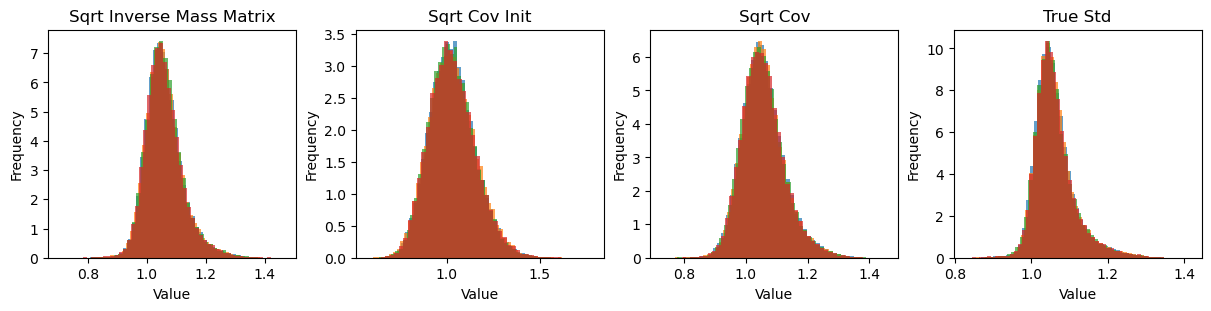

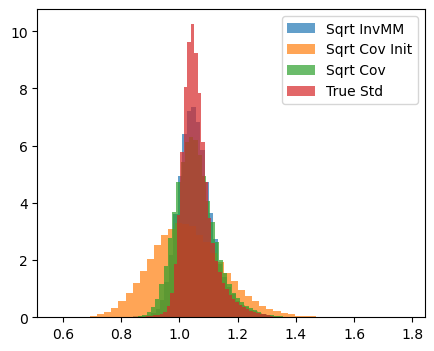

In [6]:
pth = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sMCLMC_nc4_ns64_conf.p'
sqrtinvmm = pload(pth).inverse_mass_matrix**.5
from jax.flatten_util import ravel_pytree
@vmap
def unrav(x, proto):
    unravel_fn = ravel_pytree(proto)[1]
    return unravel_fn(x)
sqrtinvmm = unrav(sqrtinvmm, init_params_)

pth = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sNUTS_nc4_ns1024'
sqrt_diag_cov = vmap(partial(get_sqrt_diag_cov_from_numpyro, all=False))(pload(pth + "_init_last_state.p"), init_params_)
sqrt_diag_cov2= vmap(partial(get_sqrt_diag_cov_from_numpyro, all=True))(pload(pth + "_last_state.p"), init_params_)

pth = '/feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_nob/sMCLMC_nc4_ns64_nomm_moment.p'
mom = pload(pth)
true_std = tree.map(lambda x: x[...,1], mom)
true_std = {k:v for k,v in true_std.items() if k not in ['n_evals']}

fig, axs = plt.subplots(1, 4, figsize=(12, 3), layout='constrained')
# Histogram of inverse mass matrix values
sqrtinvmm_values = np.concatenate([v.reshape(4,-1) for v in sqrtinvmm.values()], axis=1)
print(sqrtinvmm_values.shape)
for i in range(sqrtinvmm_values.shape[0]):
    axs[0].hist(sqrtinvmm_values[i], alpha=0.7, bins=50, density=True)
axs[0].set_title('Sqrt Inverse Mass Matrix'), axs[0].set_xlabel('Value'), axs[0].set_ylabel('Frequency')

# Histogram of sqrt_diag_cov values
sqrt_diag_cov_values = np.concatenate([v.reshape(4,-1) for v in sqrt_diag_cov.values()], axis=1)
print(sqrt_diag_cov_values.shape)
for i in range(sqrt_diag_cov_values.shape[0]):
    axs[1].hist(sqrt_diag_cov_values[i], bins=50, alpha=0.7, density=True)
axs[1].set_title('Sqrt Cov Init'), axs[1].set_xlabel('Value'), axs[1].set_ylabel('Frequency')

# Histogram of sqrt_diag_cov2 values
sqrt_diag_cov_values2 = np.concatenate([v.reshape(4,-1) for v in sqrt_diag_cov2.values()], axis=1)
print(sqrt_diag_cov_values2.shape)
for i in range(sqrt_diag_cov_values2.shape[0]):
    axs[2].hist(sqrt_diag_cov_values2[i], bins=50, alpha=0.7, density=True)
axs[2].set_title('Sqrt Cov'), axs[2].set_xlabel('Value'), axs[2].set_ylabel('Frequency')

# Histogram of true_std values
true_std_value = np.concatenate([v.reshape(4,-1) for v in true_std.values()], axis=1)
print(true_std_value.shape)
for i in range(true_std_value.shape[0]):
    axs[3].hist(true_std_value[i], bins=50, alpha=0.7, density=True)
axs[3].set_title('True Std'), axs[3].set_xlabel('Value'), axs[3].set_ylabel('Frequency')

plt.figure(figsize=(5, 4))
plt.hist(sqrtinvmm_values.flatten(), bins=50, density=True, alpha=0.7, label='Sqrt InvMM')
plt.hist(sqrt_diag_cov_values.flatten(), bins=50, density=True, alpha=0.7, label='Sqrt Cov Init')
plt.hist(sqrt_diag_cov_values2.flatten(), bins=50, density=True, alpha=0.7, label='Sqrt Cov')
plt.hist(true_std_value.flatten(), bins=50, density=True, alpha=0.7, label='True Std')
plt.legend();

In [29]:
import numpy as np
import jax.numpy as jnp
from functools import partial

from scipy.special import legendre
from jaxpm.growth import growth_rate, growth_factor
from jaxpm.kernels import cic_compensation
from montecosmo.nbody import rfftk
from montecosmo.utils import safe_div

from numpyro.diagnostics import effective_sample_size, gelman_rubin
# from blackjax.diagnostics import effective_sample_size
from jax_cosmo import Cosmology


def _waves(mesh_shape, box_shape, kedges, los):
    """
    Parameters
    ----------
    mesh_shape : tuple of int
        Shape of the mesh grid.
    box_shape : tuple of float
        Physical dimensions of the box.
    kedges : None, int, float, or list
        * If None, set dk to twice the minimum.
        * If int, specifies number of edges.
        * If float, specifies dk.
    los : array_like
        Line-of-sight vector.

    Returns
    -------
    kedges : ndarray
        Edges of the bins.
    kmesh : ndarray
        Wavenumber mesh.
    mumesh : ndarray
        Cosine mesh.
    rfftw : ndarray
        RFFT weights accounting for Hermitian symmetry.
    """
    kmax = np.pi * np.min(mesh_shape / box_shape) # = knyquist

    if isinstance(kedges, (type(None), int, float)):
        if kedges is None:
            dk = 2*np.pi / np.min(box_shape) * 2 # twice the fundamental wavenumber
        if isinstance(kedges, int):
            dk = kmax / kedges # final number of bins will be kedges-1
        elif isinstance(kedges, float):
            dk = kedges
        kedges = np.arange(0, kmax, dk) + dk/2 # from dk/2 to kmax-dk/2

    kvec = rfftk(mesh_shape) # cell units
    kvec = [ki * (m / b) for ki, m, b in zip(kvec, mesh_shape, box_shape)] # h/Mpc physical units
    kmesh = sum(ki**2 for ki in kvec)**0.5

    if los is None:
        mumesh = 0.
    else:
        mumesh = sum(ki * losi for ki, losi in zip(kvec, los))
        mumesh = safe_div(mumesh, kmesh)

    rfftw = np.full_like(kmesh, 2)
    rfftw[..., 0] = 1
    if mesh_shape[-1] % 2 == 0:
        rfftw[..., -1] = 1

    return kedges, kmesh, mumesh, rfftw


def spectrum2(mmk, mesh_shape, box_shape=None, kedges:int|float|list=None, 
             comp=(False, False), poles=0, los:np.ndarray=None):
    """
    Compute the auto and cross spectrum of 3D fields, with multipole.
    """
    # Initialize
    if box_shape is None:
        box_shape = mesh_shape
    else:
        box_shape = np.asarray(box_shape)

    if poles==0:
        los = None
    else:
        los = np.asarray(los)
        los /= np.linalg.norm(los)
    poles = np.atleast_1d(poles)

    # FFTs and compensations
    if isinstance(comp, int):
        comp = (comp, comp)

    # Binning
    kedges, kmesh, mumesh, rfftw = _waves(mesh_shape, box_shape, kedges, los)
    n_bins = len(kedges) + 1
    dig = np.digitize(kmesh.reshape(-1), kedges)

    # Count wavenumber in bins
    kcount = np.bincount(dig, weights=rfftw.reshape(-1), minlength=n_bins)
    kcount = kcount[1:-1]

    # Average wavenumber values in bins
    # kavg = (kedges[1:] + kedges[:-1]) / 2
    kavg = np.bincount(dig, weights=(kmesh * rfftw).reshape(-1), minlength=n_bins)
    kavg = kavg[1:-1] / kcount

    # Average wavenumber power in bins
    pow = jnp.empty((len(poles), n_bins))
    for i_ell, ell in enumerate(poles):
        weights = (mmk * (2*ell+1) * legendre(ell)(mumesh) * rfftw).reshape(-1)
        psum = jnp.bincount(dig, weights=weights, length=n_bins)
        pow = pow.at[i_ell].set(psum)
    pow = pow[:,1:-1] / kcount * (box_shape / mesh_shape).prod() # from cell units to [Mpc/h]^3

    # kpow = jnp.concatenate([kavg[None], pk])
    if los is None:
        return kavg, pow[0]
    else:
        return kavg, pow


In [30]:
from montecosmo.utils import rg2cgh, cgh2rg
from montecosmo.plot import plot_mesh, plot_pow
kpows = []

mmk = vmap(partial(rg2cgh, amp=True))(sqrtinvmm['init_mesh_'])**2
kpow = vmap(lambda x: spectrum2(x, model.mesh_shape, model.box_shape, poles=(0,2,4), los=(0.,0,1)))(mmk)
kpows.append(kpow)

mmk = vmap(partial(rg2cgh, amp=True))(sqrt_diag_cov['init_mesh_'])**2
kpow = vmap(lambda x: spectrum2(x, model.mesh_shape, model.box_shape, poles=(0,2,4), los=(0.,0,1)))(mmk)
kpows.append(kpow)

mmk = vmap(partial(rg2cgh, amp=True))(sqrt_diag_cov2['init_mesh_'])**2
kpow = vmap(lambda x: spectrum2(x, model.mesh_shape, model.box_shape, poles=(0,2,4), los=(0.,0,1)))(mmk)
kpows.append(kpow)

mmk = vmap(partial(rg2cgh, amp=True))(true_std['init_mesh_'])**2
kpow = vmap(lambda x: spectrum2(x, model.mesh_shape, model.box_shape, poles=(0,2,4), los=(0.,0,1)))(mmk)
kpows.append(kpow)

init_params = jit(vmap(partial(model.init_model, delta_obs=truth['obs']-1, base=True)))(jr.split(jr.key(45), mcmc.num_chains))
mmk = vmap(lambda x: jnp.abs(jnp.fft.rfftn(jnp.fft.irfftn(x), norm='ortho'))**2)(init_params['init_mesh'])
kpow = vmap(lambda x: spectrum2(x, model.mesh_shape, model.box_shape, poles=(0,2,4), los=(0.,0,1)))(mmk)
kpows.append(kpow)

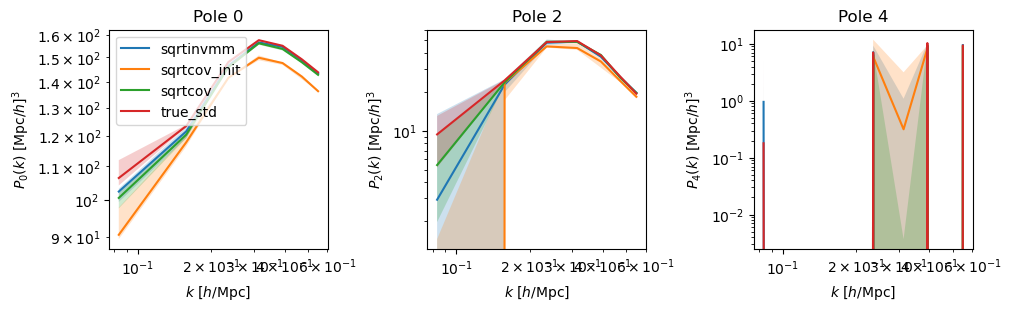

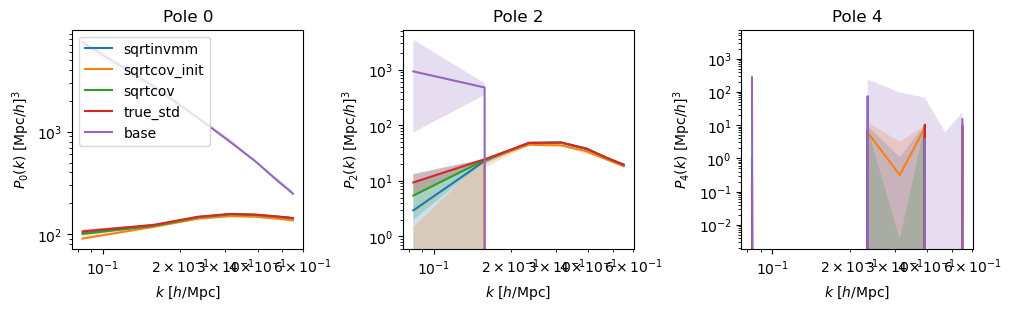

In [35]:
plt.figure(figsize=(10, 3), layout='constrained')
fill = .95
log = True
labl = ['sqrtinvmm', 'sqrtcov_init', 'sqrtcov', 'true_std', 'base']
for i_plt in range(3):
    plt.subplot(1, 3, i_plt+1)
    for i in range(len(kpows)-1):
        plot_pow(*kpows[i], ell=[0,2,4][i_plt], log=log, fill=fill)
        kmed = tree.map(lambda x: jnp.median(x, 0), kpows[i])
        plot_pow(*kmed, ell=[0,2,4][i_plt], log=log, label=labl[i])
    plt.title(f'Pole {[0,2,4][i_plt]}')
    if i_plt ==0:
        plt.legend(loc='upper left')

plt.figure(figsize=(10, 3), layout='constrained')
for i_plt in range(3):
    plt.subplot(1, 3, i_plt+1)
    for i in range(len(kpows)):
        plot_pow(*kpows[i], ell=[0,2,4][i_plt], log=log, fill=fill)
        kmed = tree.map(lambda x: jnp.median(x, 0), kpows[i])
        plot_pow(*kmed, ell=[0,2,4][i_plt], log=log, label=labl[i])
    plt.title(f'Pole {[0,2,4][i_plt]}')
    if i_plt ==0:
        plt.legend(loc='upper left')

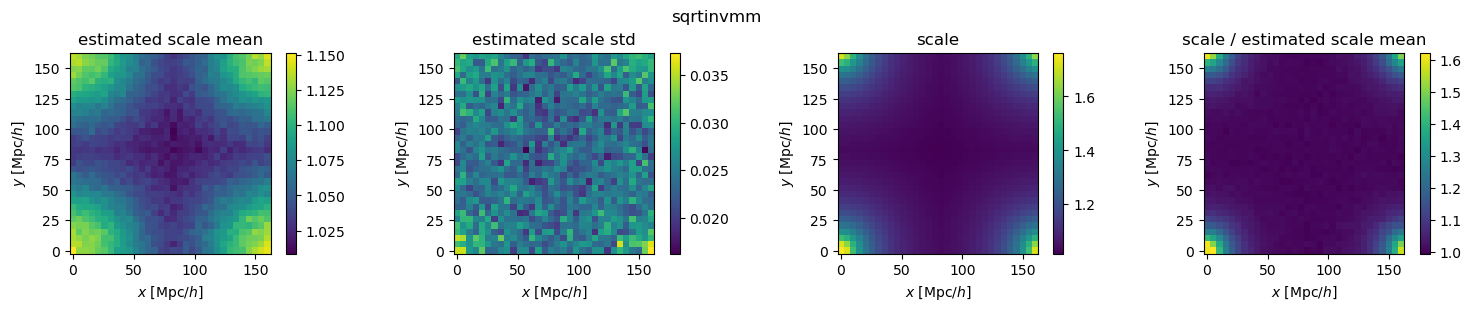

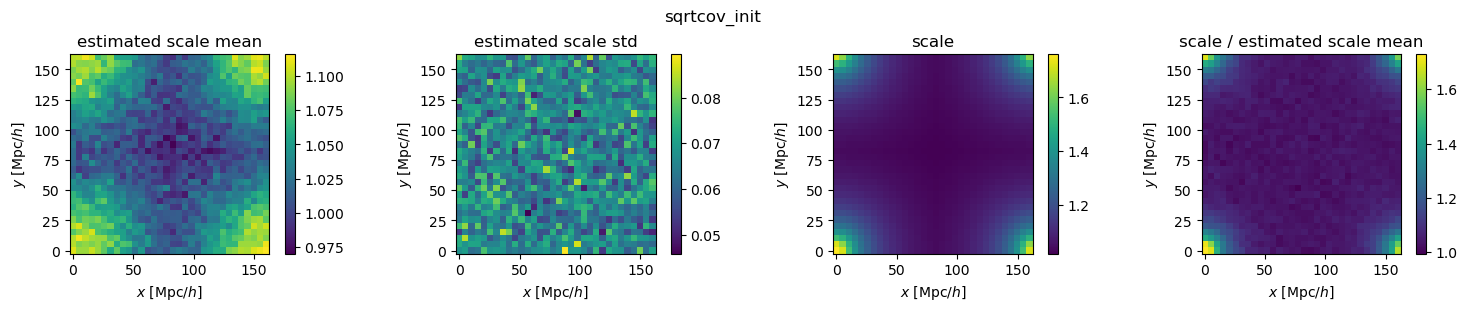

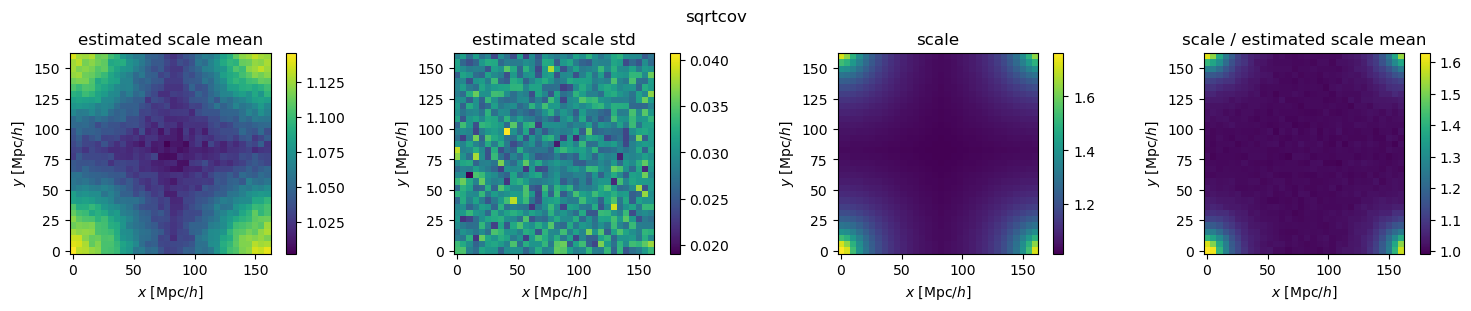

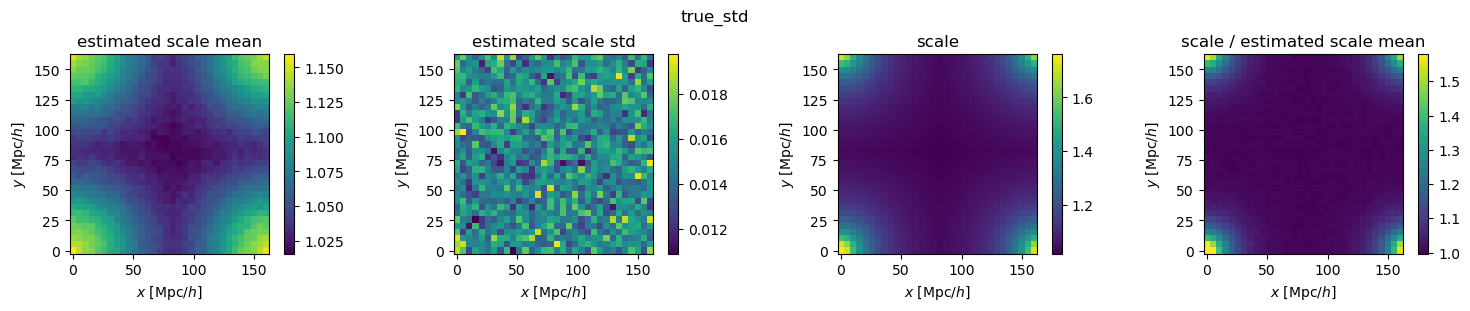

In [33]:
from montecosmo.plot import plot_mesh
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
cosmo = Planck18()
scale, transfer = model._precond_scale_and_transfer(cosmo)
scale = rg2cgh(scale, amp=True)
sli = None

labl = ['sqrtinvmm', 'sqrtcov_init', 'sqrtcov', 'true_std', 'base']
for stds, lab in zip([sqrtinvmm, sqrt_diag_cov, sqrt_diag_cov2, true_std], labl):
    plt.figure(figsize=(15, 3), layout='constrained')
    plt.suptitle(lab)

    est_scale = vmap(partial(rg2cgh, amp=True))(stds['init_mesh_'])
    est_scale_mean, est_scale_std = est_scale.mean(0), est_scale.std(0)
    plt.subplot(141)
    plot_mesh(est_scale_mean, model.box_shape, sli=sli)
    plt.title('estimated scale mean')
    plt.colorbar()

    plt.subplot(142)
    plot_mesh(est_scale_std, model.box_shape, sli=sli)
    plt.title('estimated scale std')
    plt.colorbar()

    plt.subplot(143)
    plot_mesh(scale, model.box_shape, sli=sli)
    plt.title('scale')
    plt.colorbar()

    plt.subplot(144)
    plot_mesh(scale / est_scale_mean, model.box_shape, sli=sli)
    plt.title('scale / estimated scale mean')
    plt.colorbar()

In [ ]:
from tqdm import tqdm
if mcmc_config['sampler'] in ['NUTS', 'HMC']:
    mcmc = get_mcmc(model.model, mcmc_config)
    if continue_run:
        print(f"{jnp.result_type(True)=}") # HACK: why is it working?!!
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 3 ###############
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=44, extra_fields=['num_steps'])

    else:
        # mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)
        mcmc_runned = sample_and_save(mcmc, save_path, 0, 0, extra_fields=['num_steps'], init_params=init_params_)
       

elif mcmc_config['sampler'] == 'NUTSWG':
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    # warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    # state = jit(vmap(init_state_fn))(init_params_)

    # samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    # print("conf:", conf,
    #         "\n\ninfos:", infos, '\n#################\n')
    # jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    # pdump(state, save_path+f"_last_state.p")
    # pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    conf = pload(save_path+'_conf.p')
    state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, n_samples, progress_bar=False)))
    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, end+1)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")

elif mcmc_config['sampler'] == 'MCLMC':
    from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
    from jax.flatten_util import ravel_pytree

    if mcmc_config['mm']:
        sdc = ravel_pytree(tree.map(lambda x:x.mean(0), sqrt_diag_cov))[0]
    else:
        sdc = 1.
        
    config = None
    # config = {'L':193, 'step_size': 45,} # 64^3
    # config = {'L':500, 'step_size': 10,} # 64^3 norsdb
    # config = {'L':350, 'step_size': 3,} # 64^3 a=.5
    # config = {'L':700, 'step_size':45, 'inverse_mass_matrix':sdc**2} # 64, 128^3 a=.5

    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_samples=2**13, config=config, 
                                          desired_energy_var=5e-5, diagonal_preconditioning=mcmc_config['mm'])))
    state, config = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), init_params_)
    pdump(state, save_path+f"_last_state.p")
    pdump(config, save_path+f"_conf.p")

    # state = pload(save_path+f"_last_state.p")
    # config = pload(save_path+f"_conf.p")
    print(config)
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']

    thinning = 32
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))

    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, n_runs + start)):
        print(f"run {i_run}/{n_runs}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("\nmean square energy fluctation per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
        jnp.savez(save_path+f"_{i_run}.npz", **samples)
        pdump(state, save_path+f"_last_state.p")

Adaptation start: finding L, ss, mm
fractune3=0.5
